In [51]:
import os
from dotenv import load_dotenv

import google.generativeai as genai

from IPython.display import Markdown
from IPython.display import Image, display

from chromadb import Documents, EmbeddingFunction, Embeddings
from google.api_core import retry

from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_chroma import Chroma

from typing_extensions import TypedDict
from typing import Annotated, Literal, Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

from pydantic import BaseModel, Field

from langgraph.prebuilt import tools_condition

import chromadb

import pprint

load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ['USER_AGENT'] = 'myagent' # Fix error message from langchain

In [7]:
for model in genai.list_models():
  if 'embedContent' in model.supported_generation_methods:
    print(model.name)

models/embedding-001
models/text-embedding-004


## Load blog posts as documents

In [14]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

In [21]:
docs_list[0].__dict__

{'id': None,
 'metadata': {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
  'title': "LLM Powered Autonomous Agents | Lil'Log",
  'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:',
  'language': 'en'},
 'page_content': '\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      

In [22]:
documents = [doc.page_content for doc in docs_list]

## Split text in smaller chunks

In [26]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [ ]:
documents = [doc.page_content for doc in doc_splits]
documents

In [ ]:
doc_splits

In [16]:
class GeminiEmbeddingFunction(EmbeddingFunction):
    # Specify whether to generate embeddings for documents, or queries
    document_mode = True

    def __call__(self, input: Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"

        retry_policy = {"retry": retry.Retry(predicate=retry.if_transient_error)}

        response = genai.embed_content(
            model="models/text-embedding-004",
            content=input,
            task_type=embedding_task,
            request_options=retry_policy,
        )
        return response["embedding"]

In [ ]:
DB_NAME = "googelchromadb"
embed_fn = GeminiEmbeddingFunction()
embed_fn.document_mode = True

chroma_client = chromadb.Client()
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)

db.add(documents=documents, ids=[str(i) for i in range(len(documents))])

In [30]:
db.count()

563

## Query the database

In [31]:
# Switch to query mode when generating embeddings.
embed_fn.document_mode = False

# Search the Chroma DB using the specified query.
query = "What are the main components of an agent system?" 

result = db.query(query_texts=[query], n_results=1)
[[passage]] = result["documents"]

Markdown(passage)

Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

## Langchain

In [34]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
vector = embeddings.embed_query("hello, world!")
vector[:5]

[0.05168594419956207,
 -0.030764883384108543,
 -0.03062233328819275,
 -0.02802734263241291,
 0.01813093200325966]

In [40]:
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

In [41]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

## Define graph

In [43]:
class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [45]:
### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=0, streaming=True)
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=0, streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=0, streaming=True)
    # temperature=0, streaming=True
    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}




In [46]:
print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************


/home/carlajord/.pyenv/versions/3.11.10/envs/agentic_rag_tutorial/lib/python3.11/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [48]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

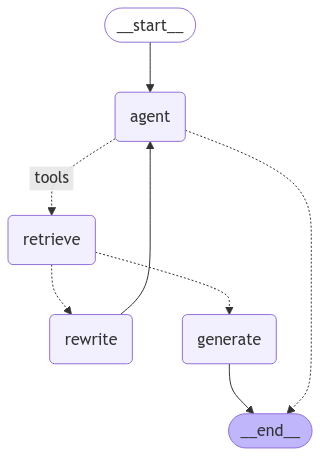

In [ ]:
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [52]:
inputs = {
    "messages": [
        ("user", "What does Lilian Weng say about the types of agent memory?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'function_call': {'name': 'retrieve_blog_posts', 'arguments': '{"query": "agent memory"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-437670f6-3d90-4252-b4d5-957f46dacd49-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'agent memory'}, 'id': 'a5360a50-b995-4828-883d-c62bb1ba86c3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 78, 'output_tokens': 18, 'total_tokens': 96, 'input_token_details': {'ca

/home/carlajord/.pyenv/versions/3.11.10/envs/agentic_rag_tutorial/lib/python3.11/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{ 'messages': [ 'Lilian Weng describes three types of agent memory: sensory '
                'memory, short-term memory, and long-term memory. Sensory '
                'memory learns embedding representations for raw inputs, '
                'short-term memory is in-context learning, and long-term '
                'memory is an external vector store accessible via fast '
                'retrieval. \n']}
'\n---\n'
